---

---

**Summary**

This project aims to scrape website information about product pricing and perform a prediction on new data.

The data included likes, dislikes, followers, and price from January 1, 2019 to December 31, 2023 on the "My Retail Store" Website.

To build a machine learning model, the following steps are implemented in this notebook: 
1. Import Packages
2. Scrape Website Information
3. Explore the Data
4. Prepare the Data (Feature Engineering)
5. Train and Test Regression Models
6. Evaluate the Best Model

More details can be found in each line of code below.

\begin{exercise}
1) Give a short description of  the algorithms used in this notebook. You can use chatGPT to produce a summary of each algorithm.
2) Find a similar dataset from various sources or by scraping a commercial web site and apply the same algorithms and compare them.
3) Prepare a report with your findings. 
4) Prepare to make presentation on this material
\end{exercise}

**Results**

The selected model is the GaussianProcessRegressor. As the name implies, it uses Gaussian processes for regression purposes.  

The GaussianProcessRegressor was able to achieve a Root Mean Squared Error (RMSE) of 0.0285 and a run-time of 0.01 seconds. K fold cross-validation (k=10) based on RMSE was also conducted in order to estimate how well the model would perform with new data. The average RMSE among folds was 0.0429. 

**Sources:** [[1]](https://scikit-learn.org/stable/modules/gaussian_process.html), [[2]](https://www.youtube.com/watch?v=iDzaoEwd0N0), [[3]](https://www.mygreatlearning.com/blog/cross-validation/#sh212)

---

### 1) Import Packages

In [40]:
!pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
#Importing Standard packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from datetime import datetime, date, timedelta
import time
from time import strptime

In [42]:
#Web Scraping

#Library used for making HTTP Requests
import requests

#Library used to parse HTML 
from bs4 import BeautifulSoup as bs

In [43]:
!pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
#Feature Engineering Packages
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler
from feature_engine.datetime import DatetimeFeatures

In [45]:
#Train Test Split
from sklearn.model_selection import train_test_split

In [46]:
#Regressors
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lars
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestRegressor

In [47]:
# Model Selection
from sklearn.model_selection import (RepeatedStratifiedKFold, 
                                     GridSearchCV, 
                                     RandomizedSearchCV,
                                     cross_val_score)

In [48]:
# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

In [49]:
# Set Options for display
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.4f}'.format
sns.set_style("whitegrid")
sns.set_context("paper", font_scale = 2)

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

---

### 2) Information

Not fount the similar datasets and i generate one.

In [50]:
# Create an array of dates
dates = pd.date_range(start='2020-01-01', end='2021-12-31', freq='D')

In [51]:
# Create random data for likes, dislikes, followers, and price
likes = np.random.randint(0, 1000, len(dates))
dislikes = np.random.randint(0, 400, len(dates))
followers = np.random.randint(0, 10000, len(dates))
price = np.random.uniform(0, 200, len(dates))

In [52]:
# Combine the data into a DataFrame
df = pd.DataFrame({
    'date': dates,
    'likes': likes,
    'dislikes': dislikes,
    'followers': followers,
    'price': price
})

In [53]:
# Save to CSV File - commented out to avoid generating a new CSV file
df.to_csv("My Store Website Data.csv")

---

### 3) Explore the Data

In [54]:
# Preview Data
df.head(3)

,date,likes,dislikes,followers,price
0,2020-01-01,260,355,9459,73.4418
1,2020-01-02,121,293,2765,143.4754
2,2020-01-03,714,106,986,120.5636


In [55]:
# Obtain summary statistics of numerical features
df.describe()

,likes,dislikes,followers,price
count,731.0000,731.0000,731.0000,731.0000
mean,495.1628,193.7579,4976.0055,100.7015
std,291.6371,112.5197,2904.8533,57.0471
min,0.0000,0.0000,2.0000,0.1165
25%,240.0000,96.5000,2407.5000,52.5503
50%,500.0000,185.0000,4939.0000,99.8064
75%,755.0000,286.5000,7309.0000,151.6373
max,997.0000,399.0000,9999.0000,199.8371


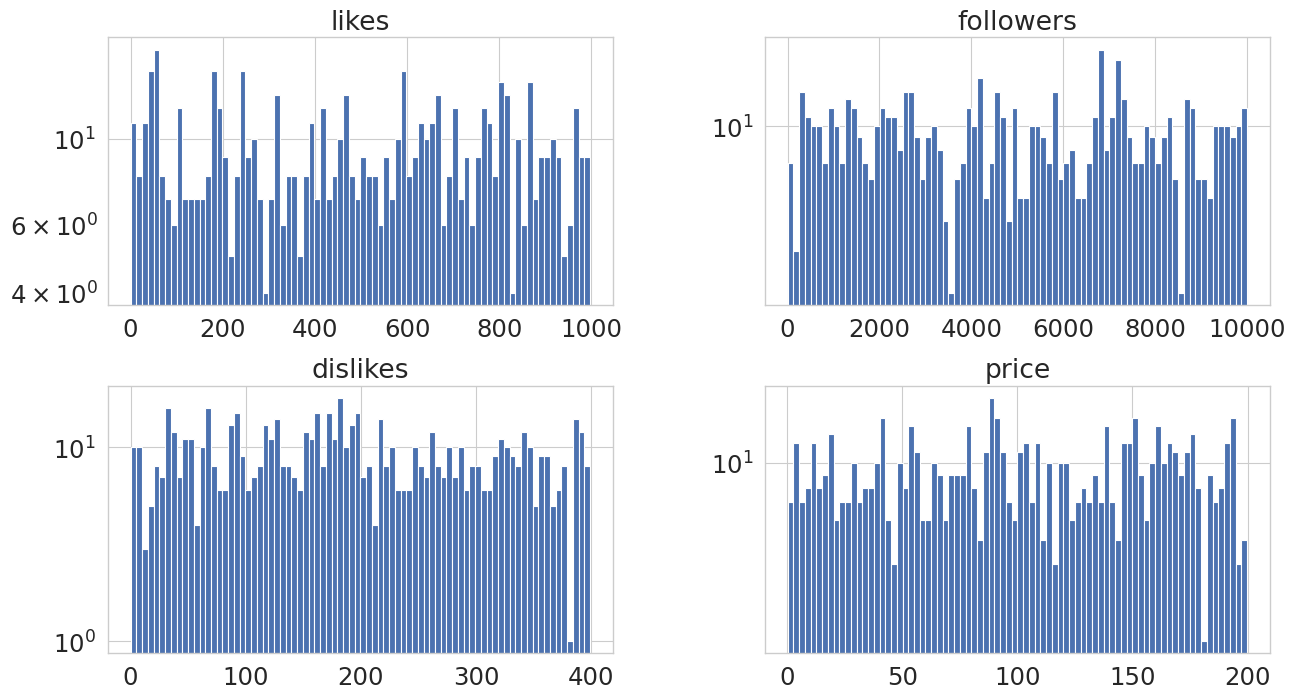

In [56]:
#displaying the distribution of each numerical feature on a logarithmic scale
df.hist(column = ['likes','followers','dislikes','price'], bins = 80, figsize = (15,8), log = True);

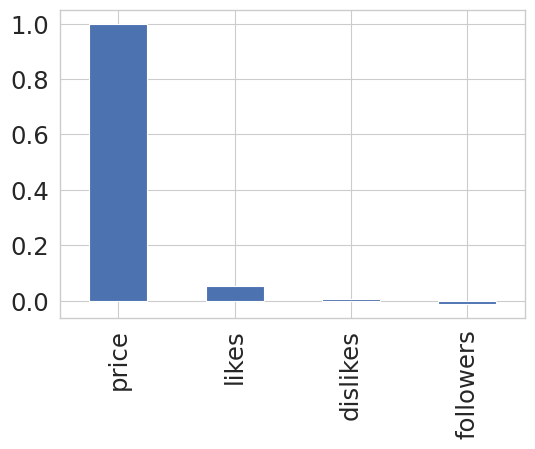

In [57]:
# Visualize and Sort numerical features based on correlation to target
bars = df.corr()['price'].sort_values(ascending=False).plot(kind='bar')

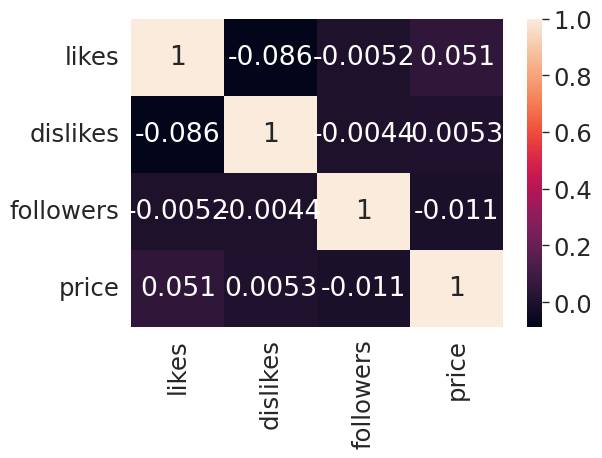

In [58]:
# Visualize heatmap of correlations between all numerical columns
heatmap = sns.heatmap(df.corr(), annot=True)

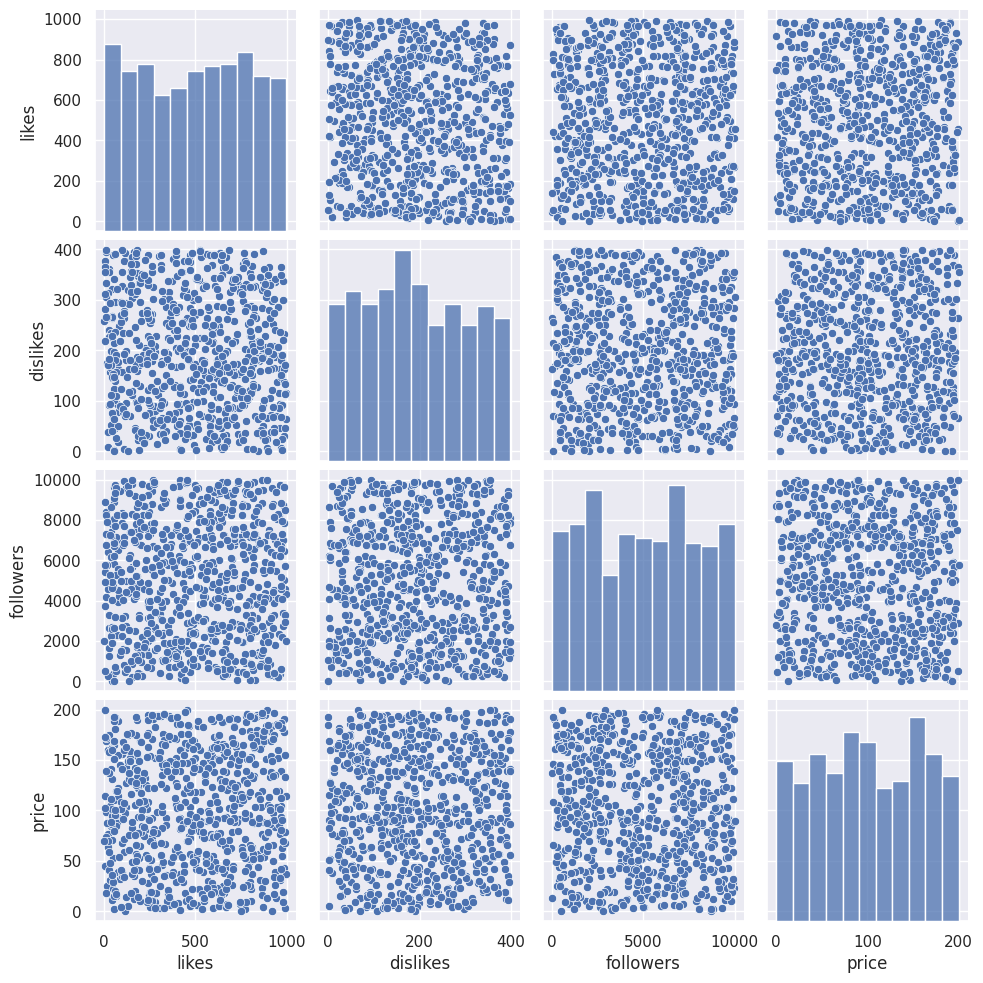

In [59]:
# Plot relationship of numerical features
sns.set(font_scale=1)
sns.pairplot(df);

---

### 4) Data Preparation / Feature Engineering

#### a) Feature Engineering for Datetime

In [60]:
# Create Dataframe of Date
df_date = pd.DataFrame(df['date'])
df_date.head(3)

,date
0,2020-01-01
1,2020-01-02
2,2020-01-03


In [61]:
# Instantiate the Feature Engineering Object
dtf = DatetimeFeatures(features_to_extract = ["year", "month", "quarter","day_of_week","weekend"])

In [62]:
# Fit and Transform on Date Dataframe
df_date = dtf.fit_transform(df_date)

In [63]:
# Add Features to Original Dataframe
df = pd.concat([df, df_date], axis=1)

In [64]:
# Drop Date Column
df = df.drop('date',axis = 1)

In [65]:
# Check Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   likes             731 non-null    int64  
 1   dislikes          731 non-null    int64  
 2   followers         731 non-null    int64  
 3   price             731 non-null    float64
 4   date_year         731 non-null    int64  
 5   date_month        731 non-null    int64  
 6   date_quarter      731 non-null    int64  
 7   date_day_of_week  731 non-null    int64  
 8   date_weekend      731 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 51.5 KB


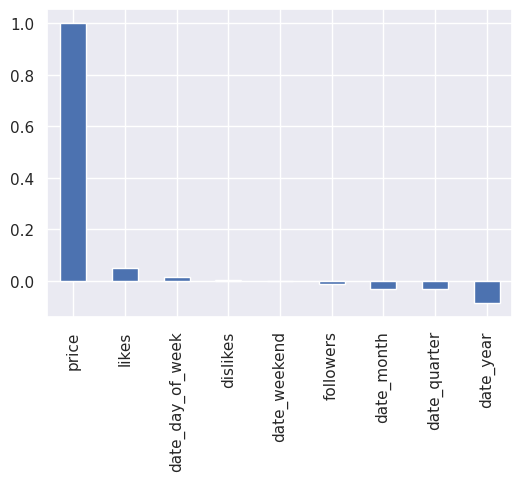

In [66]:
# Visualize and Sort all features based on correlation to target

bars = df.corr()['price'].sort_values(ascending=False).plot(kind='bar')

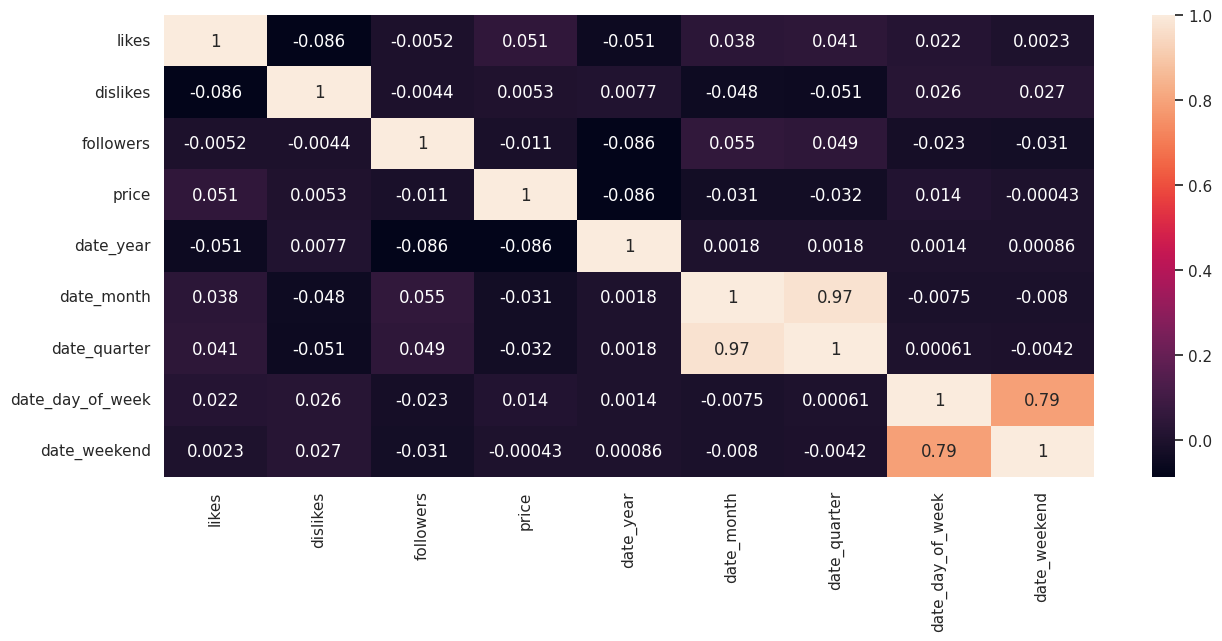

In [67]:
# Visualize heatmap of correlations between all columns
plt.figure(figsize=(15,6))
heatmap = sns.heatmap(df.corr(), annot=True)

In [68]:
# Drop Day of Week and Month, since these are highly correlated with other date time features
df = df.drop(['date_year','date_month','date_day_of_week'],axis=1)

#### b) Train-Test Split

In [69]:
# Create traning and testing datasets
x = df.drop('price',axis=1)
y = df['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

#### c) Scale Numeric Features

In [70]:
# Instantiate Column Transformer to apply Standard Scaler to relevant columns and ignore/passthrough remaning date time columns
ct = ColumnTransformer([("scaler", StandardScaler(),['likes','dislikes','followers'])],
                        remainder = 'passthrough') 

In [71]:
# Apply Scaler to Numeric Columns
  # Fit based on training data only to avoid leakage
  # Transform on both training and test data
x_train_sc = ct.fit_transform(x_train)
x_test_sc = ct.transform(x_test)

---

### 5) Train and Test Regression Models

In [72]:
# Creating a Dictionary of Regressors
  #random state added to applicable regressors
  #max_iter increased for some regressors to improve fit

regressors = {
    "XGBRegressor": XGBRegressor(random_state = 17),
    "RandomForestRegressor": RandomForestRegressor(random_state = 17),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state = 17),
    "GaussianProcessRegressor": GaussianProcessRegressor(random_state = 17),
    "SVR": SVR(),
    "NuSVR": NuSVR(),
    "Ridge":Ridge(random_state = 17),
    "Lars": Lars(normalize=False,random_state = 17),
    "TheilSenRegressor": TheilSenRegressor(random_state = 17),
    "HuberRegressor": HuberRegressor(max_iter= 400),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter = 2000,random_state = 17),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(random_state = 17),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(normalize=False),
}

In [73]:
# Testing all Regressors

# Creating blank dataframe for performance metrics
df_models = pd.DataFrame(columns=['model', 'run_time', 'rmse','cross_val_rmse_average','cross_val_rmse_scores'])

#looping through dictionary of regressors
for key in regressors:

    # printing progress
    print('*',key) 

    # recording run time
    start_time = time.time() 

    # instantiating regressor
    regressor = regressors[key] 

    # training regressor on training data
    model = regressor.fit(x_train_sc, y_train) 

    # predicting on testing data
    y_pred = model.predict(x_test_sc) 

    # obtaining scores from cross validation with 10 folds based on rmse
    scores = cross_val_score(model, 
                             x_train_sc, 
                             y_train,
                             scoring= 'neg_root_mean_squared_error',
                             cv=10) 

    # storing performance information in a dictionary
    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),  
           'rmse': round(np.sqrt(mean_squared_error(y_test, y_pred)),4),
           'cross_val_rmse_average': abs(scores.mean()), #average of cross validation scores
           'cross_val_rmse_scores': scores #list of cross validation scores
    }

    # adding performance information dictionary to dataframe
    df_models = df_models.append(row, ignore_index=True)

* XGBRegressor
* RandomForestRegressor
* DecisionTreeRegressor
* GaussianProcessRegressor
* SVR
* NuSVR
* Ridge
* Lars
* TheilSenRegressor
* HuberRegressor
* PassiveAggressiveRegressor
* ARDRegression
* BayesianRidge
* ElasticNet
* OrthogonalMatchingPursuit


In [74]:
# Order Performance Results of All Models

df_models.head(20).sort_values(by='rmse', ascending=True)

,model,run_time,rmse,cross_val_rmse_average,cross_val_rmse_scores
5,NuSVR,0.01,58.4136,56.5668,"[-54.29626090350457, -55.48643648282128, -59.3..."
12,BayesianRidge,0.0,58.4243,56.5095,"[-54.38972471246364, -55.18060073510605, -59.6..."
14,OrthogonalMatchingPursuit,0.0,58.4535,57.0136,"[-54.5359487413552, -56.475029241992026, -59.9..."
11,ARDRegression,0.0,58.4543,56.7727,"[-54.41155909573102, -56.003324821356564, -59...."
13,ElasticNet,0.0,58.5822,56.5953,"[-54.16609388417542, -55.7226124625612, -59.55..."
8,TheilSenRegressor,0.26,58.7398,56.8470,"[-54.18075143292546, -56.806328906002555, -59...."
6,Ridge,0.0,58.7934,56.7428,"[-53.92901058694661, -56.18522812882758, -59.5..."
7,Lars,0.0,58.7945,56.7443,"[-53.92835488881936, -56.18825610850193, -59.5..."
9,HuberRegressor,0.0,58.9576,56.9317,"[-53.75491107806182, -56.54401372189776, -59.6..."
4,SVR,0.01,59.0247,56.7187,"[-54.456762126507684, -55.76947379080632, -60...."


---

### 6) Evaluate Best Model

In [75]:
# Train the best model and Predict on the Test Set

regressor = GaussianProcessRegressor(random_state = 17)
model = regressor.fit(x_train_sc, y_train)
y_pred = model.predict(x_test_sc)

In [76]:
# Defining a function to get the model's key metrics

def get_metrics(y_testdata,y_predicteddata):
    MAE = round(mean_absolute_error(y_testdata,y_predicteddata),4)
    MSE = round(mean_squared_error(y_testdata,y_predicteddata),4)
    RMSE = round(np.sqrt(MSE),4)
    R2 = round(r2_score(y_testdata,y_predicteddata),4)
    
    print(f'Mean absolute error = {MAE}')
    print(f'Mean squared error = {MSE}')
    print(f'Root mean squared error = {RMSE}')
    print(f'R Squared = {R2}')
    
    return MAE, MSE, RMSE, R2

In [77]:
# Applying the function to get key metrics
get_metrics(y_test,y_pred);

Mean absolute error = 170.3857
Mean squared error = 52943.7695
Root mean squared error = 230.0951
R Squared = -14.5462


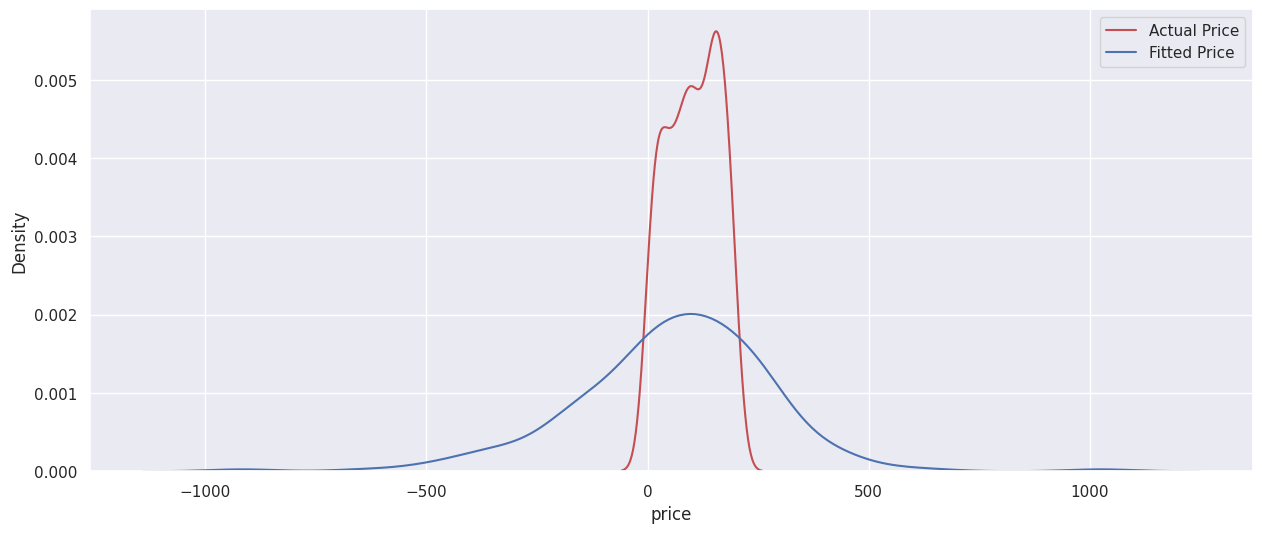

In [78]:
# Distribution plot of actual and predicted values

plt.figure(figsize=(15,6))
ax1 = sns.kdeplot(y_test, color="r", label="Actual Price")
sns.kdeplot(y_pred, color="b", label="Fitted Price" , ax=ax1)
sns.set(rc={"figure.figsize":(6, 4)})
plt.legend()
plt.show();

In [79]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Generate some data
import numpy as np
X = np.array([[1., 2.], [3., 4.], [5., 6.]])
y = np.array([1.0, 2.0, 3.0])

# Define the kernel
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))

# Create the Gaussian process regressor
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1, n_restarts_optimizer=10)

# Fit the Gaussian process regressor to the data
gp.fit(X, y)

# Predict on some new data
X_new = np.array([[0., 0.], [2., 2.], [4., 4.]])
y_pred, sigma = gp.predict(X_new, return_std=True)
print(y_pred, sigma )

[0.41917645 1.2586546  2.24859229] [0.48534965 0.28137718 0.26863802]
